In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
project_path = ('/content/gdrive/My Drive/DATA_690_NLP/Text_Summarization/')
sys.path.append(project_path)

Mounted at /content/gdrive/


**This process is loosely based on this article: https://towardsdatascience.com/beyond-classification-with-transformers-and-hugging-face-d38c75f574fb**

In [2]:
!pip install transformers

     |████████████████████████████████| 2.1MB 5.6MB/s 
     |████████████████████████████████| 3.3MB 34.4MB/s 
     |████████████████████████████████| 870kB 36.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=94a99989e44a9dcade0a2b78ee603461f74ff625718d146573116b9a76319a9a
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [3]:
import torch
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertConfig, BertModel, BertTokenizer
import seaborn as sns
sns.set()
% matplotlib inline
np.random.seed(0);

In [4]:
model_name = "bert-base-uncased"
TOTAL_NO_LAYERS = 12
TOTAL_NO_ATTEN_HEADS = 12
CMAP = sns.light_palette("blue")

In [5]:
articles_df = pd.read_csv(f'{project_path}/Data_cleaning/Telehealth_article.csv')

longest_article = 0
for index, article in enumerate(articles_df['Content']):
  
  article_length = len(article.split())
  print(f'article {index + 1} has {len(article)} characters and {article_length} tokens')
  if article_length > longest_article:
    longest_article = article_length
print(f'the longest article is {longest_article}')

article 1 has 37572 characters and 5546 tokens
article 2 has 74163 characters and 10898 tokens
article 3 has 63651 characters and 8785 tokens
article 4 has 30199 characters and 4146 tokens
article 5 has 42480 characters and 6701 tokens
article 6 has 43373 characters and 6172 tokens
article 7 has 37408 characters and 5396 tokens
article 8 has 25679 characters and 3636 tokens
article 9 has 32142 characters and 4809 tokens
article 10 has 12048 characters and 1739 tokens
article 11 has 22502 characters and 3310 tokens
article 12 has 61009 characters and 8738 tokens
article 13 has 33054 characters and 4651 tokens
article 14 has 49449 characters and 6973 tokens
article 15 has 29501 characters and 4298 tokens
article 16 has 40410 characters and 5918 tokens
article 17 has 43283 characters and 6683 tokens
article 18 has 33874 characters and 5045 tokens
article 19 has 36649 characters and 5196 tokens
article 20 has 41792 characters and 5969 tokens
article 21 has 36755 characters and 5119 tokens


In [6]:
config = BertConfig.from_pretrained(model_name, output_attentions=True)
bert_model = BertModel.from_pretrained(model_name, config=config)
bert_model.eval()
bert_tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)


In [7]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

article_vectors = []

for article in articles_df['Content'].values:

  sentence_tokens = sent_tokenize(article)

  sentence_vectors = []

  for index, sentence in enumerate(sentence_tokens):
    tokens = bert_tokenizer(sentence, return_tensors='pt', return_attention_mask=True)
    output = bert_model(tokens.input_ids)

    latent_matrix = output.last_hidden_state.detach().numpy()
    sentence_vectors.append(np.mean(latent_matrix, axis=1)[0])
    
  article_vector = np.mean(np.array(sentence_vectors), axis=0)

  article_vectors.append(article_vector)

article_vectors = np.array(article_vectors)

print(article_vectors.shape)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
(44, 768)


In [8]:
article_vectors_df = pd.DataFrame(article_vectors)
article_vectors_df.to_csv(f'{project_path}/Data/articles_latent_space.csv')

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
matrix = pca.fit_transform(article_vectors)
print(matrix.shape)

(44, 2)


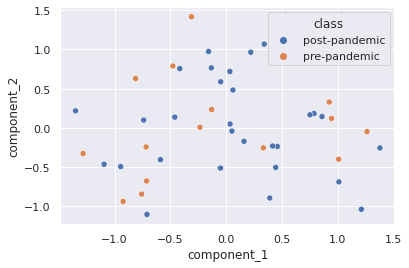

In [10]:
import seaborn as sns
import datetime

components_df = pd.DataFrame({'component_1': matrix[:,0], 'component_2': matrix[:,1]})
components_df['year'] = pd.to_numeric(articles_df['Date Published'])
components_df['class'] = components_df['year'].apply(lambda x: 'pre-pandemic' if x < 2020 else 'post-pandemic')
sns.scatterplot(data=components_df, x='component_1', y='component_2', hue='class')

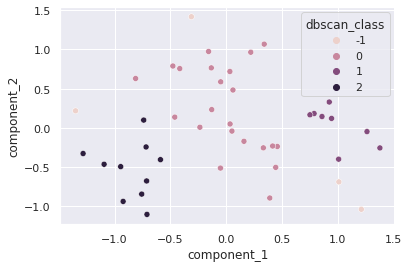

In [38]:
from sklearn.cluster import DBSCAN

dbscan_clusters = DBSCAN(eps=0.45, metric='euclidean').fit_predict(matrix)

components_df['dbscan_class'] = dbscan_clusters

sns.scatterplot(data=components_df, x='component_1', y='component_2', hue='dbscan_class')